# Annie Yan
**Steam Game Recommender System**

annie.yq.yan@gmail.com

<h1 align='center'>Steam Game Recommender</h1>
<h2 align='center'> K-Means, Cosine Similarity, FunkSVD Modeling</h2>

# Table of Contents

* [Introduction](#Introduction)
* [Methodology](#Methodology)
    * [Programming Language Info](#Programming)
    * [Importing Data](#Data)
* [Further Model Exploration](#Model)
    * [K-Means](#Kmeans)
    * [FunkSVD](#FunkSVD)
* [Concluding Remarks](#Conclude)

<a name='Introduction'></a>
## Introduction

This is a continuation of the other modeling notebook: Steam Game Recommender - Part 3 User Independent, Content Cosine Similarity Modeling

Other recommendation system modeling techniques are explored.

This notebook is 3 of 4 notebooks to be used for this project. This specific notebook (paired with the other Part 3 Notebook) aims to explore more complex recommendation modeling options. 

Please refer to:
- Part 1 for data pre-processing, where the initial major data cleaning was completed.
- Part 2 for exploratory data analysis and visualization, with some additional data wrangling.
- Part 4 for model evaluation.

<a name='Methodology'></a>
## Methodology

<a name='Programming'></a>
### Programming Language
Python with additionally imported libaries will be the language of choice for this project.

In [559]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns

In [560]:
# Shows all columns when previewing information
pd.set_option('display.max_columns', None)

In [561]:
# Printing version of library being used. 
print('NumPy Version: ', np.__version__)
print('Pandas Version: ', pd.__version__)
print('Seaborn Version: ', sns.__version__)
print('Matplotlib Version: ', mpl.__version__)

NumPy Version:  1.23.1
Pandas Version:  1.4.3
Seaborn Version:  0.12.2
Matplotlib Version:  3.7.1


Version control, for purpose of troubleshooting in the event of version incompatibility.

These are the versions of the libraries that were used when running this notebook:
- NumPy Version:  1.23.1
- Pandas Version:  1.4.3
- Seaborn Version:  0.12.2
- Matplotlib Version:  3.7.1

<a name='Data'></a>
### Importing Data

In [178]:
games = pd.read_csv('clean_data/cleaned_steam_games.csv', index_col='AppID')
# alt_games = pd.read_csv('clean_data/cleaned_alt_steam_games.csv')

In [268]:
final_games = pd.read_pickle('clean_data/final_steam_games.pkl')

In [85]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70563 entries, 10 to 2458330
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      70563 non-null  object 
 1   Estimated owners          70563 non-null  object 
 2   Required age              70563 non-null  int64  
 3   Price                     70563 non-null  float64
 4   DLC count                 70563 non-null  int64  
 5   About the game            70563 non-null  object 
 6   Supported languages       70563 non-null  object 
 7   Full audio languages      70563 non-null  object 
 8   Windows                   70563 non-null  int64  
 9   Mac                       70563 non-null  int64  
 10  Linux                     70563 non-null  int64  
 11  Metacritic score          70563 non-null  int64  
 12  Positive                  70563 non-null  int64  
 13  Negative                  70563 non-null  int64  
 14  Ach

In [7]:
recommendations = pd.read_csv('clean_data/cleaned_recommendations.csv')

In [8]:
recommendations.head()

,app_id,helpful,funny,is_recommended,hours,user_id,review_id,review_year,review_month
0,975370,0,0,1,36.3,47199,0,2022,12
1,304390,4,0,0,11.5,2376,1,2017,2
2,1085660,2,0,1,336.5,230757,2,2019,11
3,703080,0,0,1,27.4,235736,3,2022,9
4,526870,0,0,1,7.9,21721,4,2021,1


In [9]:
users = pd.read_csv('clean_data/users.csv')

In [10]:
users.head()

,user_id,products,reviews
0,6784920,359,0
1,12917080,156,1
2,8079864,329,4
3,4422752,176,3
4,4747757,98,2


#### Re-fixing `final_games`:

In [277]:
# Checking current shape
final_games.shape

(70563, 550)

In [291]:
# Checking current columns
final_games.columns

Index(['Required age', 'Price', 'DLC count', 'Windows', 'Mac', 'Linux',
       'Metacritic score', 'Positive', 'Negative', 'Achievements',
       ...
       'tags_Werewolves', 'tags_Western', 'tags_Wholesome', 'tags_Word Game',
       'tags_World War I', 'tags_World War II', 'tags_Wrestling',
       'tags_Zombies', 'tags_e-sports', 'tags_eSports'],
      dtype='object', length=550)

In [292]:
# Dropping extraneous columns: positive and negative (as done in other part 3 notebook)
final_games.drop(columns=['Positive', 'Negative'], axis=1, inplace=True)

In [293]:
# Confirming dataset looks correct
final_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70563 entries, 10 to 2458330
Columns: 548 entries, Required age to tags_eSports
dtypes: Sparse[int32, 0](521), float64(2), int64(11), uint8(14)
memory usage: 18.4 MB


#### Truncating `final_games` Dataset

In [333]:
recommendations['app_id'].nunique()

32942

A 70,563 game dataframe is quite large and computationally expensive, it will be truncated to improve runtime. For future analysis (and with better resources), a larger scale model could be created.

From the `recommendations` dataframe, it can be seen that only about 33 thousand unique games have some sort of review associated with them. This is a little less than half of the 70 thousand list from the `games`/`final_games` list. 

Only game IDs found in this list will be included in the `all_game_info` matrix. 

**`final_games`**

In [349]:
final_games.head()

,Required age,Price,DLC count,Windows,Mac,Linux,Metacritic score,Achievements,Recommendations,Median playtime forever,Release year,Release month,Weighted_Vote_Sentiment,est_owners_0 - 0,est_owners_0 - 20000,est_owners_100000 - 200000,est_owners_1000000 - 2000000,est_owners_10000000 - 20000000,est_owners_100000000 - 200000000,est_owners_20000 - 50000,est_owners_200000 - 500000,est_owners_2000000 - 5000000,est_owners_20000000 - 50000000,est_owners_50000 - 100000,est_owners_500000 - 1000000,est_owners_5000000 - 10000000,est_owners_50000000 - 100000000,categories_Captions available,categories_Co-op,categories_Commentary available,categories_Cross-Platform Multiplayer,categories_Full controller support,categories_In-App Purchases,categories_Includes Source SDK,categories_Includes level editor,categories_LAN Co-op,categories_LAN PvP,categories_MMO,categories_Mods,categories_Mods (require HL2),categories_Multi-player,categories_Online Co-op,categories_Online PvP,categories_Partial Controller Support,categories_PvP,categories_Remote Play Together,categories_Remote Play on Phone,categories_Remote Play on TV,categories_Remote Play on Tablet,categories_Shared/Split Screen,categories_Shared/Split Screen Co-op,categories_Shared/Split Screen PvP,categories_Single-player,categories_Stats,categories_Steam Achievements,categories_Steam Cloud,categories_Steam Leaderboards,categories_Steam Trading Cards,categories_Steam Turn Notifications,categories_Steam Workshop,categories_SteamVR Collectibles,categories_Tracked Controller Support,categories_Tracked Motion Controller Support,categories_VR Only,categories_VR Support,categories_VR Supported,categories_Valve Anti-Cheat enabled,genres_Accounting,genres_Action,genres_Adventure,genres_Animation & Modeling,genres_Audio Production,genres_Casual,genres_Design & Illustration,genres_Early Access,genres_Education,genres_Free to Play,genres_Game Development,genres_Gore,genres_Indie,genres_Massively Multiplayer,genres_Movie,genres_Nudity,genres_RPG,genres_Racing,genres_Sexual Content,genres_Simulation,genres_Sports,genres_Strategy,genres_Unlabeled,genres_Video Production,genres_Violent,genres_Web Publishing,tags_1980s,tags_1990's,tags_2.5D,tags_2D,tags_2D Fighter,tags_2D Platformer,tags_360 Video,tags_3D,tags_3D Fighter,tags_3D Platformer,tags_3D Vision,tags_4 Player Local,tags_4X,tags_6DOF,tags_8-bit Music,tags_ATV,tags_Abstract,tags_Action,tags_Action RPG,tags_Action RTS,tags_Action Roguelike,tags_Action-Adventure,tags_Addictive,tags_Adventure,tags_Agriculture,tags_Aliens,tags_Alternate History,tags_Ambient,tags_America,tags_Animation & Modeling,tags_Anime,tags_Arcade,tags_Archery,tags_Arena Shooter,tags_Artificial Intelligence,tags_Assassin,tags_Asymmetric VR,tags_Asynchronous Multiplayer,tags_Atmospheric,tags_Audio Production,tags_Auto Battler,tags_Automation,tags_Automobile Sim,tags_BMX,tags_Base Building,tags_Base-Building,tags_Baseball,tags_Based On A Novel,tags_Basketball,tags_Batman,tags_Battle Royale,tags_Beat 'em up,tags_Beautiful,tags_Benchmark,tags_Bikes,tags_Birds,tags_Blood,tags_Board Game,tags_Boss Rush,tags_Bowling,tags_Boxing,tags_Building,tags_Bullet Hell,tags_Bullet Time,tags_CRPG,tags_Capitalism,tags_Card Battler,tags_Card Game,tags_Cartoon,tags_Cartoony,tags_Casual,tags_Cats,tags_Character Action Game,tags_Character Customization,tags_Chess,tags_Choices Matter,tags_Choose Your Own Adventure,tags_Cinematic,tags_City Builder,tags_Class-Based,tags_Classic,tags_Clicker,tags_Co-op,tags_Co-op Campaign,tags_Coding,tags_Cold War,tags_Collectathon,tags_Colony Sim,tags_Colorful,tags_Combat,tags_Combat Racing,tags_Comedy,tags_Comic Book,tags_Competitive,tags_Conspiracy,tags_Controller,tags_Conversation,tags_Cooking,tags_Cozy,tags_Crafting,tags_Creature Collector,tags_Cricket,tags_Crime,tags_Crowdfunded,tags_Cult Classic,tags_Cute,tags_Cyberpunk,tags_Cycling,tags_Dark,tags_Dark Comedy,tags_Dark Fantasy,tags_Dark Humor,tags_Dating Sim,tags_Deckbuilding,tags_Demons,tags_Design & Illustration,tags_De

In [334]:
# Game ID present in recommendations dataset
short_list = list(recommendations['app_id'].unique())

In [335]:
# Keeping only games that are present in recommendation dataset
final_games = final_games[final_games.index.isin(short_list)]

In [337]:
# Checking final reduced shape
final_games.shape

(32196, 548)

**`games`**

In [350]:
# Completing same steps for games dataset as 'About the game' is needed
games = games[games.index.isin(short_list)]

In [351]:
# Checking shape matches
games.shape

(32196, 25)

#### Scaling the shortned list of `final_games` and applying principal component analysis (PCA) 

In [338]:
# Importing StandardScaler library
from sklearn.preprocessing import StandardScaler

# Instantiating standard scaler, fitting and transforming final_games data
ss = StandardScaler()
scaled_data = ss.fit_transform(final_games)

C:\Users\ayqya\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ayqya\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [339]:
# Importing PCA library
from sklearn.decomposition import PCA

# Instantiating PCA and fit/transforming on scaled final_games data
# Preliminary number of principal components chosen
pca = PCA(n_components=len(final_games.columns))
pca_data = pca.fit_transform(scaled_data)

In [340]:
# Getting explained variance for analysis of optimizing principal components
expl_var = pca.explained_variance_ratio_

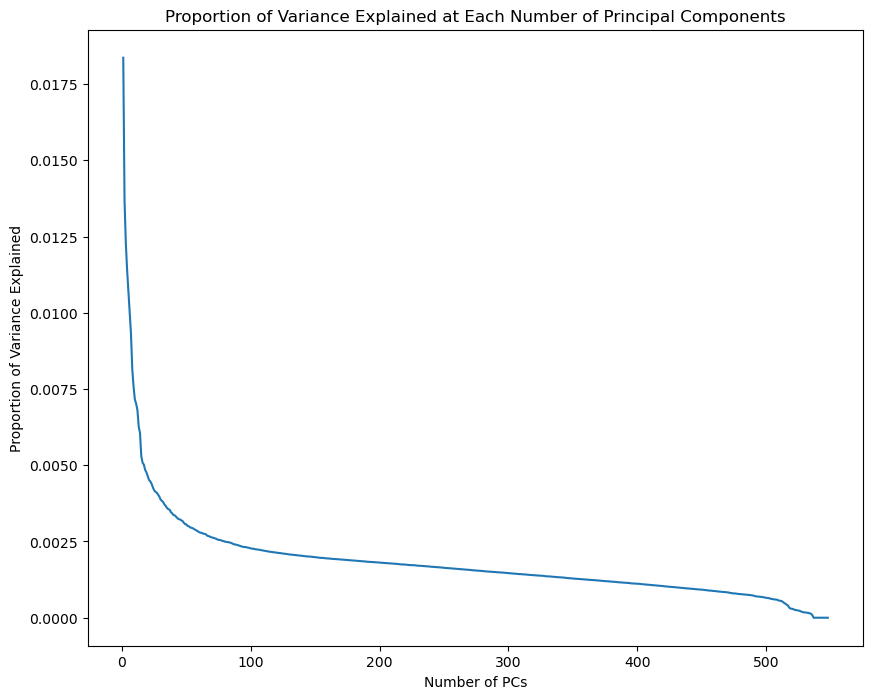

In [341]:
# Plotting explained variance ratio
plt.figure(figsize=(10,8))
plt.plot(range(1,len(final_games.columns)+1), expl_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained at Each Number of Principal Components')

plt.show()

It can be seen that the elbow is difficult to determine and the values of proportional variance explained are very low at each step. Thus, an analysis based on the cumulative sum of explained variance would be better in this case.

In [342]:
# Calculating cumulative explained variance
cumulative_sum = np.cumsum(expl_var)

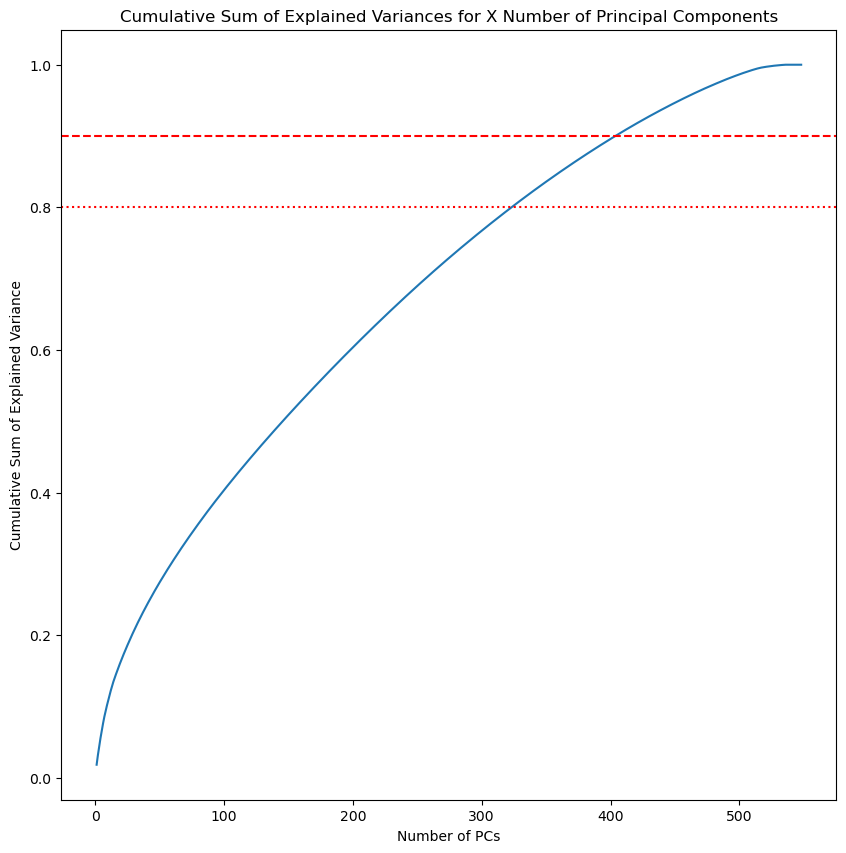

In [343]:
# Plotting cumulative explained variance, with markers for 90% and 80% explained variance
plt.figure(figsize=(10,10))
plt.plot(range(1,len(final_games.columns)+1), cumulative_sum)
plt.axhline(0.9, c='r', linestyle='--')
plt.axhline(0.8, c='r', linestyle='dotted')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Cumulative Sum of Explained Variances for X Number of Principal Components')

plt.show()

In [344]:
# Creating dataframe of cumulative explained variance
cumulative_sum_df = pd.DataFrame(cumulative_sum, 
                                 index=range(1,len(final_games.columns)+1), 
                                 columns=['Cumulative Explained Variance'])

# Finding # PCA for 0.9 (90%) explained variance
cumulative_sum_df[cumulative_sum_df['Cumulative Explained Variance']>=0.9].head(1)

,Cumulative Explained Variance
404,0.900363


In [345]:
# Finding # PCA for 0.8 (80%) explained variance
cumulative_sum_df[cumulative_sum_df['Cumulative Explained Variance']>=0.8].head(1)

,Cumulative Explained Variance
324,0.801307


In [346]:
# Re-instantiating PCA with 'optimized' number of components, fitting and transforming on scaled data again
pca = PCA(n_components=404)
pca_data = pca.fit_transform(scaled_data)

#### Vectorizing shortened list of `About the game` (game descriptions) using TfidfVectorizer

In [352]:
# Importing TfidfVectorizer library
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiating vectorizer, setting min_df=2 to reduce the resultant size of the matrix
# Fitting and transforming the game description data for the shortened list of games
description_vectorizer = TfidfVectorizer(stop_words = "english", min_df=2)
description_tfidf_matrix = description_vectorizer.fit_transform(games['About the game'])

In [353]:
# Checking resulting matrix
description_tfidf_matrix

<32196x46039 sparse matrix of type '<class 'numpy.float64'>'
	with 2958377 stored elements in Compressed Sparse Row format>

#### Combining the PCA'd `final_game` data with the `About the game` Tfidf vectorized matrix

In [354]:
# Importing necessary scipy sparse libraries to work with and convert sparse matrices
import scipy.sparse
from scipy.sparse import hstack

In [355]:
# Converting PCA'd final game data to CSR matrix
sparse_pca = scipy.sparse.csr_matrix(pca_data)

In [356]:
# Checking result
sparse_pca

<32196x404 sparse matrix of type '<class 'numpy.float64'>'
	with 13007184 stored elements in Compressed Sparse Row format>

In [357]:
# Combining the two datasets into final game info dataset
all_game_info = scipy.sparse.hstack((sparse_pca, description_tfidf_matrix))

In [358]:
# Checking resulting sparrce matrix
all_game_info

<32196x46443 sparse matrix of type '<class 'numpy.float64'>'
	with 15965561 stored elements in COOrdinate format>

In [359]:
# Converting from COO to CSR format
all_game_info = all_game_info.tocsr()

The above steps were already previously done and discussed in the other modeling notebook, so commentary has been excluded.

These data processing steps were re-created on a smaller list of games so that another model utilizing K-Means could be epxlored. 

## K-Means Clustering

Groupings of games can be created using an unsupervised learning method, such as the K-Means clustering model; it is a 'distance'-based model that will group items into clusters that are supposed to be similar. This creates smaller game groupings that are easier to work with.

A cosine similarity can be run on the smaller subset of games to return games based on a scored similarity. 

This is an experimental hybrid model that is being tested, without expectation of high utility results. 

In [545]:
# Checking the size of the dataframe that will be used to run tests on this model
all_game_info.shape

(32196, 46443)

In [360]:
# Importing kmeans library
from sklearn.cluster import KMeans

In [362]:
# Initialize and fit a k-means to truncated list of 32k games
# Setting random number of clusters to 300
kmeans = KMeans(n_clusters=300, init='k-means++', random_state=42)
kmeans.fit(all_game_info)

KMeans(n_clusters=300, random_state=42)

In [364]:
# Checking labels
kmeans.labels_

array([ 79, 174, 278, ..., 163,  17, 248])

In [573]:
# Importing game ID and name reference dataFrame
game_names = pd.read_csv('clean_data/steam_game_id.csv')

In [574]:
game_names.head()

,AppID,Name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force


In [575]:
# Checking shape
game_names.shape

(70563, 2)

In [576]:
# Truncating game list to same size as one used on KMean model
game_names = game_names[game_names['AppID'].isin(short_list)]

In [577]:
# Checking to ensure shape matches
game_names.shape

(32196, 2)

In [578]:
# kmeans label shape check to match rows
kmeans.labels_.shape

(32196,)

In [642]:
# Creating a dataframe with cluster info
game_cluster_info = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [643]:
# Checking result
game_cluster_info.head()

,cluster
0,79
1,174
2,278
3,278
4,278


In [644]:
# Concatenating the game reference ids to the cluster ids
game_cluster_info = pd.DataFrame(np.hstack((game_names,game_cluster_info)))

In [645]:
# Renaming the columns for descriptive purposes
game_cluster_info = game_cluster_info.rename(columns={0:'AppID', 1:'game', 2:'cluster'})

In [646]:
# Checking result
game_cluster_info.head()

,AppID,game,cluster
0,10,Counter-Strike,79
1,20,Team Fortress Classic,174
2,30,Day of Defeat,278
3,40,Deathmatch Classic,278
4,50,Half-Life: Opposing Force,278


In [647]:
# Taking a look at the 10 largest clusters
game_cluster_info['cluster'].value_counts().head(10)

45     1805
21     1628
198    1049
168    1011
163     900
141     494
187     474
25      463
213     434
169     420
Name: cluster, dtype: int64

In [737]:
# Checking shape of data
game_cluster_info.shape

(32196, 3)

In [690]:
# Locating the cluster of a sample game
game_cluster_info[game_cluster_info['game']=='Risk of Rain 2']

,AppID,game,cluster
10661,632360,Risk of Rain 2,278


In [649]:
# Locating the cluster of another sample game
game_cluster_info[game_cluster_info['game']=='Devil May Cry 5']

,AppID,game,cluster
10016,601150,Devil May Cry 5,212


In [691]:
# Taking a look at what is contained the cluster for the sample game
game_cluster_info[game_cluster_info['cluster']==278]

,AppID,game,cluster
2,30,Day of Defeat,278
3,40,Deathmatch Classic,278
4,50,Half-Life: Opposing Force,278
5,60,Ricochet,278
6,70,Half-Life,278
180,8870,BioShock Infinite,278
182,8930,Sid Meier's Civilization® V,278
208,10180,Call of Duty®: Modern Warfare® 2 (2009),278
869,96000,The Tiny Bang Story,278
911,107410,Arma 3,278


In [671]:
# Import cosine similarity library
from sklearn.metrics.pairwise import cosine_similarity

In [717]:
# Creating cluster dataframe for games in cluster 278
cluster_df = game_cluster_info[game_cluster_info['cluster']==278]

In [718]:
# Checking resultant dataframe
cluster_df.head()

,AppID,game,cluster
2,30,Day of Defeat,278
3,40,Deathmatch Classic,278
4,50,Half-Life: Opposing Force,278
5,60,Ricochet,278
6,70,Half-Life,278


In [719]:
# Checking shape
cluster_df.shape

(57, 3)

In [720]:
# Finding the row/index of the reference game to be used for cosine similarity
row_index = cluster_df.index[cluster_df['game']=='Risk of Rain 2'].values[0]

In [722]:
# Getting data of just the reference row
ref_game = all_game_info.getrow(row_index)

In [723]:
# Checking shape
ref_game

<1x46443 sparse matrix of type '<class 'numpy.float64'>'
	with 499 stored elements in Compressed Sparse Row format>

In [724]:
# Getting the rest of the information for games within the cluster
cluster_games = all_game_info[list(cluster_df.index), :]

In [725]:
# Checking shape matches
cluster_games

<57x46443 sparse matrix of type '<class 'numpy.float64'>'
	with 30190 stored elements in Compressed Sparse Row format>

In [726]:
# Running cosine similarity of the cluster
cluster_similarity = cosine_similarity(ref_game, cluster_games)

In [727]:
# Checking result
cluster_similarity.shape

(1, 57)

In [728]:
# Creating similarity score dataframe
similarity_df = pd.DataFrame(cluster_similarity.squeeze())

In [729]:
# Checking shape
similarity_df.shape

(57, 1)

In [731]:
# Checking matching shape for concatenation
cluster_df.shape

(57, 3)

In [732]:
# Reseting index 
cluster_df.reset_index(inplace=True)

In [734]:
# Concatenating similarity scores to the cluster's dataframe
cluster_df = pd.concat((cluster_df, similarity_df), axis=1).rename(columns={0:'similarity'})

In [736]:
# Comparing top 10 games within the cluster, based on similarity score, to Risk of Rain 2
cluster_df.sort_values(by='similarity', ascending=False).head(10)

,index,AppID,game,cluster,similarity
42,10661,632360,Risk of Rain 2,278,1.000000
34,4718,377160,Fallout 4,278,0.644144
53,20012,1145360,Hades,278,0.587778
33,4649,374320,DARK SOULS™ III,278,0.584775
10,1015,204360,Castle Crashers®,278,0.577906
19,1638,250900,The Binding of Isaac: Rebirth,278,0.557330
23,2123,275850,No Man's Sky,278,0.556937
31,4454,367520,Hollow Knight,278,0.552894
50,15567,883710,Resident Evil 2,278,0.536732
35,5018,387990,Scrap Mechanic,278,0.526648


In [767]:
# Checking game cluster list
game_cluster_info.head()

,AppID,game,cluster
0,10,Counter-Strike,79
1,20,Team Fortress Classic,174
2,30,Day of Defeat,278
3,40,Deathmatch Classic,278
4,50,Half-Life: Opposing Force,278


In [745]:
def cluster_cosim(game_input, game_cluster_info=game_cluster_info, all_game_info=all_game_info):
    # Find which cluster the game input is in
    cluster_num = game_cluster_info.loc[game_cluster_info['game']==game_input, 'cluster'].values[0]

    # Create a DataFrame of all games within the cluster
    cluster_df = game_cluster_info[game_cluster_info['cluster']==cluster_num]

    # Fine the index row of the game_input
    row_index = cluster_df.index[cluster_df['game']== game_input].values[0]

    # Get the game_input from the sparse matrix of all game info
    ref_game = all_game_info.getrow(row_index)

    # Get the information for all other games in the same cluster as game_input
    cluster_games = all_game_info[list(cluster_df.index), :]

    # Run cosine similarity for all games within the cluster against the game_inputer
    cluster_similarity = cosine_similarity(ref_game, cluster_games)

    # Put the similarity scores into the dataframe
    cluster_df['similarity'] = cluster_similarity.flatten()

    # Get the top 10 games based on similarity score and ret=urn the dataframe
    similar_games = cluster_df.sort_values(by='similarity', ascending=False).head(10)

    return similar_games

After doing single instance test of the cluster data, a function has been created for ease of replication of the above steps for other games. Random games known by the author will be tested below:

In [746]:
cluster_cosim('Devil May Cry 5')

C:\Users\ayqya\AppData\Local\Temp\ipykernel_47220\3634651029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['similarity'] = cluster_similarity.flatten()


,AppID,game,cluster,similarity
10016,601150,Devil May Cry 5,212,1.000000
15636,887720,Devil's Hunt,212,0.716995
666,45700,Devil May Cry 4,212,0.707329
10642,631510,Devil May Cry HD Collection,212,0.686146
734,50620,Darksiders™,212,0.664051
6412,446390,Onechanbara Z2: Chaos,212,0.606862
6786,460790,Bayonetta,212,0.601715
3339,329050,Devil May Cry 4 Special Edition,212,0.583801
1405,235460,METAL GEAR RISING: REVENGEANCE,212,0.578354
26400,1580790,[NINJA GAIDEN: Master Collection] NINJA GAIDEN Σ2,212,0.574733


In [744]:
cluster_cosim('Terraria')

C:\Users\ayqya\AppData\Local\Temp\ipykernel_47220\632060278.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['similarity'] = cluster_similarity.flatten()


,AppID,game,cluster,similarity
905,105600,Terraria,47,1.000000
2053,271590,Grand Theft Auto V,47,0.921081
15727,892970,Valheim,47,0.896097
4224,359550,Tom Clancy's Rainbow Six® Siege,47,0.891649
1683,252490,Rust,47,0.884862
21589,1245620,ELDEN RING,47,0.855828
1204,218620,PAYDAY 2,47,0.756460
99,4000,Garry's Mod,47,0.750864
19015,1085660,Destiny 2,47,0.742824
16592,945360,Among Us,47,0.739007


In [747]:
cluster_cosim('Undertale')

C:\Users\ayqya\AppData\Local\Temp\ipykernel_47220\3634651029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['similarity'] = cluster_similarity.flatten()


,AppID,game,cluster,similarity
5115,391540,Undertale,284,1.000000
15342,871720,Ultimate Custom Night,284,0.598571
7798,508440,Totally Accurate Battle Simulator,284,0.550373
1465,239030,"Papers, Please",284,0.539123
16827,960090,Bloons TD 6,284,0.537126
5627,412020,Metro Exodus,284,0.532807
18462,1057090,Ori and the Will of the Wisps,284,0.447509
1292,225540,Just Cause™ 3,284,0.447292
13639,782330,DOOM Eternal,284,0.434907
1287,225260,Brutal Legend,284,0.415266


In [748]:
cluster_cosim('Dwarf Fortress')

C:\Users\ayqya\AppData\Local\Temp\ipykernel_47220\3634651029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['similarity'] = cluster_similarity.flatten()


,AppID,game,cluster,similarity
17064,975370,Dwarf Fortress,193,1.000000
25785,1538570,Patron,193,0.733051
20303,1162750,Songs of Syx,193,0.715394
11819,690830,Foundation,193,0.679472
22871,1336490,Against the Storm,193,0.672387
12658,733460,First Feudal,193,0.649330
19353,1104330,Founders' Fortune,193,0.646858
7509,496460,Life is Feudal: Forest Village,193,0.642717
17979,1029780,Going Medieval,193,0.630592
12011,700820,TFM: The First Men,193,0.613113


In [749]:
cluster_cosim('DARK SOULS™: REMASTERED')

C:\Users\ayqya\AppData\Local\Temp\ipykernel_47220\3634651029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['similarity'] = cluster_similarity.flatten()


,AppID,game,cluster,similarity
9291,570940,DARK SOULS™: REMASTERED,255,1.000000
10136,606280,Darksiders III,255,0.676312
1924,265300,Lords Of The Fallen™,255,0.596030
27986,1710170,Blade of Darkness,255,0.493644
19239,1098080,3000th Duel,255,0.478316
20448,1172380,STAR WARS Jedi: Fallen Order™,255,0.453293
21369,1230000,Curse of Eternity,255,0.449444
27574,1676740,Animus: Revenant,255,0.445010
27193,1642790,Deepening Fire,255,0.440241
24652,1459160,Dark Cave,255,0.439829


The runtime using a KMeans Cluster to cosine similarity pipeline is much faster compared to running a full cosine similarity on all games. 

Additionally, it gives similar results to the cosine similarity run in the other notebook for some games, such as Terraria, but vastly different recommendation options with other game inputs, such as those for Dark Souls. 

|Cosine Similarity|K-Means -> Cosine Similarity|
|-----------------|----------------------------|
|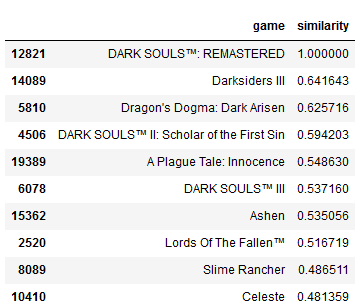|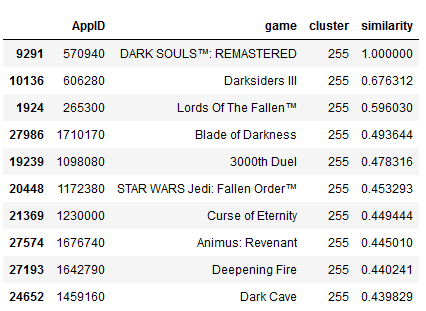|
|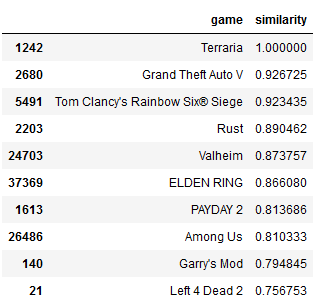|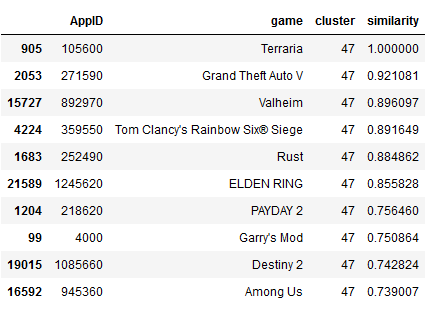|

The differences can be seen the the screenshots above. 
- The recommended, similar games for Terraria are similar in both lists--with the only difference being the order in which they are being recommended. This ordering difference could also be attributed the the changes to the Tfidf Vectorizer (min_df=2 instead of 1) and the truncated list of games being used.
- The recommended games based on similarity for Dark Souls are vastly different, with only 1-2 matches. 

Again, it is difficult to assess whether one recommendation system is better than the other since this would require more user input to give feedback on the strength of the recommendations. 

The advantages to this hybridized, experimental method include a more varied selection of options and faster runtimes. 

#### Future considerations to improve the K-Means clustering model:

An attempt was made to run multiple KMeans clustering models to optimize for the number of cluster, k-value. However, it was discovered that the process was too computationally expensive (i.e. there is significant CPU burden), so this process was stopped.

The below is the code block that was attempted, and this would be a next step/future consideration to refine the recommendation system created above. 

```python
k_range = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]

# Create an empty list for the inertia
inertia_list = []

# Testing for inertia at each k-value
for k in k_range:
    # Instantiate Kmeans model, with changing k-value and fit PCA truncated data
    # Random state = 42 for reproducibility
    k_means_model = KMeans(n_clusters=k, random_state=42)
    k_means_model.fit(pca_data)
    
    # Create list of inertias
    inertia_list.append(k_means_model.inertia_)
```

The goal would have been to look for the k-value instance where inertia change becomes incrementally smaller (i.e. the elbow of the line plot that would've been created with the code block below).

```
plt.figure()
plt.plot(k_range, inertia_list, marker="*")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot for K-means for Truncated List of Game Data')
plt.xticks(k_range)

plt.show()
```

<a name='FunkSVD'></a>
## FunkSVD with User Recommendation Data

### Dataset Reduction

The `recommendation` dataframe is comprised of 35,271,521 reviews which is computationally unfeasible to model on a single computer. Since the dataframe is so large, some investigation will be done to see if it can be truncated to a more manageable number. 

In [435]:
recommendations.shape

(35271521, 9)

In [436]:
# Number of unique Steam games based on AppID
recommendations['app_id'].nunique()

32942

For reference, there are reviews for 32,942 unique games on Steam. 

In [437]:
recommendations.head()

,app_id,helpful,funny,is_recommended,hours,user_id,review_id,review_year,review_month
0,975370,0,0,1,36.3,47199,0,2022,12
1,304390,4,0,0,11.5,2376,1,2017,2
2,1085660,2,0,1,336.5,230757,2,2019,11
3,703080,0,0,1,27.4,235736,3,2022,9
4,526870,0,0,1,7.9,21721,4,2021,1


One way to reduce the size of this dataset is to remove users who have only reviewed 1 product; such users will not provide much latent variable information since there is only 1 game data point to work from. 

In [463]:
# User ids of users with only 1 review
num_reviews = recommendations['user_id'].value_counts()
one_review_users = num_reviews[num_reviews==1].index.tolist()

In [464]:
# Number of unique reviewers for reference
recommendations['user_id'].nunique()

12623487

In [465]:
# Keeping only users who are not in the one-review list
trunc_recommendations = recommendations[~recommendations['user_id'].isin(one_review_users)]

In [466]:
# Checking resultant size of dataframe
trunc_recommendations.shape

(28144744, 9)

In [467]:
# Checking how much game information may have been lost
trunc_recommendations['app_id'].nunique()

32921

While this did reduce the number of rows from 35 million to 28 million, there are still too many to feasibly run the model.

An arbitrary, minimum number of reviews can be set for users to be included in the FunkSVD analysis/modeling. 

In this case, the 5 or more reviews and 10 or more reviews were examined. 
- With 5 or more reviews, there are still 18,098,280 reviews.
- With 10 or more reviews, this goes down to a more manageable 11,379,130 reviews.
- With 20 or more reviews, the amount of rows reduces to about 6,264,508 reviews.

In [483]:
# Thresholding and finding users who meet the threshold
num_reviews = trunc_recommendations['user_id'].value_counts()
greater20_reviews = num_reviews[num_reviews>=20].index.tolist()

In [484]:
# Keeping only users meeting threshold
trunc_recommendations = trunc_recommendations[trunc_recommendations['user_id'].isin(greater20_reviews)]

In [485]:
# Checking resultant shape
trunc_recommendations.shape

(6264508, 9)

In [486]:
# Seeing how many games were lost
trunc_recommendations['app_id'].nunique()

32366

Further truncation can be done using information on the users themselves: 

In [487]:
# Checking user information
users.head()

,user_id,products,reviews
0,6784920,359,0
1,12917080,156,1
2,8079864,329,4
3,4422752,176,3
4,4747757,98,2


In [488]:
# Checking number of users within dataset
users.shape

(13179866, 3)

The median number of products that a Steam user owns is 57, so half of all users in the given user list own less than that and half own more than that number. If only those users who own around 57 or more products are included, then the recommendations can be potentially further reduced.

In [490]:
# Checking number of users who meet minimum threshold
users[users['products']>=57].shape

(6632375, 3)

In [491]:
# User id of those who meet threshold
median_owner = users[users['products']>=57]['user_id'].tolist()

In [492]:
# Filtering out and keeping only users who meet the threshold
trunc_recommendations = trunc_recommendations[trunc_recommendations['user_id'].isin(median_owner)]

In [493]:
# Checking resultant shape
trunc_recommendations.shape

(6264508, 9)

In [494]:
trunc_recommendations.head()

,app_id,helpful,funny,is_recommended,hours,user_id,review_id,review_year,review_month
22,534380,0,0,1,40.6,20744,22,2022,10
32,438100,0,0,1,8.1,831311,32,2020,9
58,602960,0,0,1,41.9,669668,58,2022,1
130,105600,2,0,1,528.3,4101700,130,2016,10
138,570940,348,39,0,73.3,4718698,138,2021,12


In [752]:
trunc_recommendations['user_id'].value_counts().head(10)

10837767    5249
4696697     3348
10734314    3297
5216252     2991
10635837    2914
4956282     2454
3961976     2317
4090209     2277
522464      2271
6076831     2228
Name: user_id, dtype: int64

### FunkSVD Modeling

FunkSVD modeling relies on predicting the user score of unscored content/games using latent variables that are determined by existing user scores of content. 

In [498]:
# Importing necessary libraries to run the FunkSVD from surprise
from surprise import Dataset
from surprise.reader import Reader

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy

In [497]:
# Creating dataframe with only columns needed for modeling
svd_recommend = trunc_recommendations[['user_id', 'app_id', 'is_recommended']]

In [499]:
# Dataset loading needed to run model
user_game_rec = Dataset.load_from_df(svd_recommend, Reader(rating_scale=(0,1)))

In [500]:
training_dataset = user_game_rec.build_full_trainset()
training_dataset

In [501]:
# Instantiating model and fitting dataset
funksvd = FunkSVD(n_factors=100, # Arbitrary number of factors was chosen
                  n_epochs=100, # Arbitrary number of epochs was chosen
                  lr_all=0.05, # Learning rate for each epoch, a lower number was chosen to improve accuracy
                  biased=False,  
                  verbose=0)

funksvd.fit(training_dataset)

In [503]:
# Testing model accuracy
train_data, test_data = train_test_split(user_game_rec, test_size=0.25)
predictions = funksvd.test(test_data)

In [504]:
# Crreating a dataframe of the predicated values
pred_df = pd.DataFrame(predictions)

In [761]:
# Checking out actual scores vs predicated
pred_df = pred_df.rename(columns={'uid': 'user_id', 'iid':'AppID', 'r_ui':'actual_is_recommended', 'est':'predicted_recommend'})

In [762]:
pred_df.head()

,user_id,AppID,actual_is_recommended,predicted_recommend,details
0,4968658,368260,0.0,0.196207,{'was_impossible': False}
1,7385574,424280,1.0,0.991196,{'was_impossible': False}
2,5838172,1426450,1.0,0.886502,{'was_impossible': False}
3,12139049,261550,1.0,0.919836,{'was_impossible': False}
4,4131208,442120,1.0,1.000000,{'was_impossible': False}


In [505]:
FCP = accuracy.fcp(predictions, verbose=False)
print(FCP)

0.7646363645923114


The accuracy of the predicted recommendations is over 50% and hovering around 76.5% with the arbitrarily set values. It is likely/possible that this could be further improved with hyperparameter optimization and GridSearchCV, however, these methods are outside the scope of this project and require computational resources beyond what is available at the individual level.

In [763]:
pred_df[pred_df['user_id']==5838172]

,user_id,AppID,actual_is_recommended,predicted_recommend,details
2,5838172,1426450,1.0,0.886502,{'was_impossible': False}
7865,5838172,218620,1.0,0.788261,{'was_impossible': False}
343155,5838172,33930,1.0,0.981931,{'was_impossible': False}
537989,5838172,317820,1.0,0.867302,{'was_impossible': False}
716807,5838172,342180,0.0,0.423344,{'was_impossible': False}
770074,5838172,99900,1.0,0.843067,{'was_impossible': False}
811646,5838172,586030,1.0,0.978899,{'was_impossible': False}
848637,5838172,1071870,1.0,0.906468,{'was_impossible': False}
992146,5838172,405710,0.0,0.288563,{'was_impossible': False}
1233981,5838172,979690,1.0,0.761666,{'was_impossible': False}


Taking a look at a sample user, user_id=5838172, it appears that the predicted scores (when rounded to a binary not recommended (0) or recommended (1) at an arbitrary threshold of 0.5) are all in line with the actual recommendation by the user. 

In [765]:
pred_df['user_id'].sample()

486934    8155912
Name: user_id, dtype: int64

In [766]:
pred_df[pred_df['user_id']==8155912]

,user_id,AppID,actual_is_recommended,predicted_recommend,details
2328,8155912,232090,0.0,0.668442,{'was_impossible': False}
227914,8155912,1816670,0.0,0.314769,{'was_impossible': False}
288463,8155912,274170,1.0,0.800950,{'was_impossible': False}
427231,8155912,304930,1.0,0.714803,{'was_impossible': False}
486934,8155912,1782210,0.0,0.397078,{'was_impossible': False}
570159,8155912,271590,0.0,0.153425,{'was_impossible': False}
593532,8155912,620,1.0,0.843852,{'was_impossible': False}
614617,8155912,393380,1.0,0.517207,{'was_impossible': False}
651279,8155912,1237970,1.0,0.687994,{'was_impossible': False}
807795,8155912,552500,0.0,0.261638,{'was_impossible': False}


Taking a sample of another user shows similarly that the scores being predicted align well with the actual recommendation result. 

While this would make the FunkSVD model useful for making user-content recommendations, it is limited in the amount of information that it has been trained on. There are only 32 thousand unique games with reviews and/or recommended|not-recommended status, compared to the content-based system which can take into account scoring metrics alongside game characteristics for a larger set of unrated, less known games. 

Additionally, optimization of FunkSVD is difficult for large sets of data due to the limitations surrounding GridSearchCV. 

<a name='Conclude'></a>
## Concluding Remarks

### Next Steps:

Similar issues occured with optimizing the FunkSVD model as with the hybrid K-Mean Clustering - Cosine Similarity model.

Having attempted to hyperparameter optimize the FunkSVD model using a GridSearchCV, it was found that the runtime was too long to feasibly complete (i.e. greater than 48 hours without result, at the least). 

Next steps in improving this model would be to complete this step, potentially using Cloud computing resources (which are currently financially unfeasible). 

```python
param_grid = {'n_factors': [50, 100, 200], 
              'n_epochs': [10, 50, 100],
              'lr_all': [0.005, 0.1],
              'biased': [False]}
```

```python
GSCV = GridSearchCV(FunkSVD, param_grid, measures=['fcp'], cv=3)
GSCV.fit(user_game_rec)
```

A preliminary GridSearchCV would be something like the above, with further fine tuning of the values as the results are compared. 

#### Features/variables that were created but could not be incorporated into this project due to computational constraints:

There was some notable content that was not incorporated into the final modeling process: 
- One hot encoded `Supported languages` and `Full audio languages` were created but not incorporated into the final dataset/analysis. This would have added another 212 additional columns, which would increase the computational burden/increase the runtime of all models. 
- The `Developers` and `Publishers` were not used in the final recommendation results. The unique numbers of each column were too large to feasibly one hot encode without causing significant resource allocation issues. One method of utilizing this information is to create a function that compares the resultant game lists created by cosine similarity or FunkSVD and re-rank those games with the same developer/publisher higher. This would have to be explored in another project.
- The `alt_steam_games` dataset was created as an alternative to the `games`/`final_games` dataset used in this project. It contains additional scoring information not found in the `games` dataframe that may have provided interesting insights. The disadvantage to the `alt_steam_games` dataset is that it contains only around 50k game entries, which is not as comprehensive a list as the one used. 

To conclude, much more could be done to improve on the existing models created, to create new models or to add additional considerations/features to the existing models. 

However, the final products created with the tools utilized are still robust and worth considering. 